In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as ImageReader

plt.rcParams['font.size'] = 6

In [2]:
# Load the inner and the outer arrays
num_images = 150
images_path = "data/anatomicalSegmentations"
images = np.stack([np.array(ImageReader.open(f"{images_path}/{i:03d}.png")) for i in range(1, num_images + 1)])

def inner_outer_reps(image, num_reps=50):
    height, width = image.shape
    cy = height // 2
    cx = width // 2
    threshold = 128  # Adjust based on image characteristics

    inner_points = []
    outer_points = []

    for i in range(num_reps):
        theta = 2 * np.pi * i / num_reps
        dx = np.cos(theta)
        dy = np.sin(theta)

        current_x = cx
        current_y = cy
        prev_value = image[cy, cx]
        inner_found = False
        outer_found = False
        inner_point = None
        outer_point = None

        while True:
            current_x += dx
            current_y += dy
            x_int = int(round(current_x))
            y_int = int(round(current_y))
            if x_int < 0 or x_int >= width or y_int < 0 or y_int >= height:
                break
            current_value = image[y_int, x_int]
            if not inner_found:
                if prev_value < threshold <= current_value:
                    inner_point = (x_int, y_int)
                    inner_found = True
            else:
                if prev_value >= threshold > current_value:
                    outer_point = (x_int, y_int)
                    outer_found = True
                    break
            prev_value = current_value
        if inner_found:
            inner_points.append(inner_point)
        if outer_found:
            outer_points.append(outer_point)
    inner_points.append(inner_points[0])
    outer_points.append(outer_points[0])

    return np.array(inner_points), np.array(outer_points)


inner_list = []
outer_list = []

for image_arr in images:
    inner_part, outer_part = inner_outer_reps(image_arr)
    inner_list.append(inner_part)
    outer_list.append(outer_part)

inner_boundaries = np.array(inner_list)
outer_boundaries = np.array(outer_list)

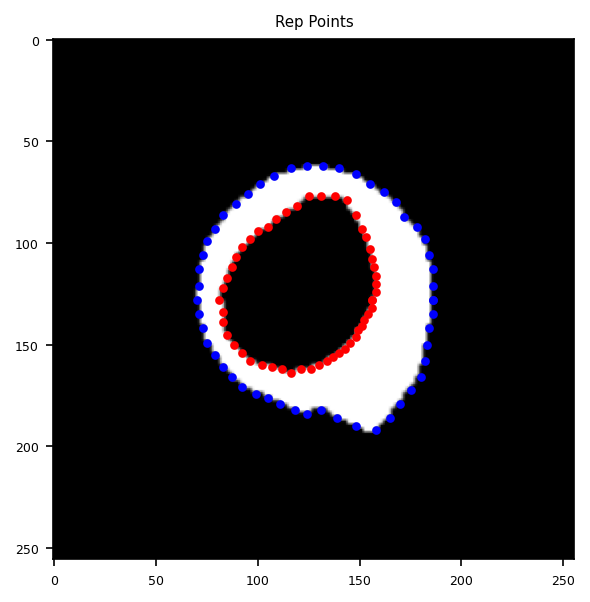

(150, 51, 2)


In [3]:
image_no = 50

plt.figure(figsize=(4, 4), dpi=150)
plt.imshow(images[image_no], cmap='gray')
plt.scatter(inner_boundaries[image_no, :, 0], inner_boundaries[image_no, :, 1], c='r', s=10)
plt.scatter(outer_boundaries[image_no, :, 0], outer_boundaries[image_no, :, 1], c='b', s=10)
plt.title(f"Rep Points")
plt.tight_layout()
plt.show()

print(inner_boundaries.shape)

In [4]:
def normalize(x):
        x = x - x.mean(axis=0)
        scale = np.linalg.norm(x)
        return x / scale


# Code 1
def align_rotation_only(x, y):  # Align Y to X
    u, _, vt = np.linalg.svd(y.T @ x)
    r = u @ vt
    return y @ r


# Code 2
def align_similarity(x, y):  # Align Y to X
    x_centered = x - x.mean(axis=0)
    y_centered = y - y.mean(axis=0)
    norm_x = np.linalg.norm(x_centered)
    norm_y = np.linalg.norm(y_centered)
    xn = x_centered / norm_x
    yn = y_centered / norm_y
    u, _, vt = np.linalg.svd(yn.T @ xn)
    r = u @ vt
    s = (norm_x / norm_y)
    t = x.mean(axis=0) - s * y.mean(axis=0) @ r
    return s * y @ r + t


def code11_combined(inner_shapes, outer_shapes, max_iter=10):
    # Combine shapes for joint alignment
    combined_shapes = [np.concatenate([i, o], axis=0) for i, o in zip(inner_shapes, outer_shapes)]
    aligned = np.array([normalize(s) for s in combined_shapes])
    mean = aligned[0]

    for _ in range(max_iter):
        aligned = np.array([align_rotation_only(mean, s) for s in aligned])
        mean = np.mean(aligned, axis=0)
        mean = normalize(mean)

    # Split back into inner and outer
    split_idx = inner_shapes[0].shape[0]
    inner_aligned = aligned[:, :split_idx, :]
    outer_aligned = aligned[:, split_idx:, :]
    inner_mean = mean[:split_idx, :]
    outer_mean = mean[split_idx:, :]

    return inner_aligned, outer_aligned, inner_mean, outer_mean


def code22(shapes, max_iter=10):
    aligned = np.copy(shapes)
    mean = aligned[0]
    for _ in range(max_iter):
        aligned = np.array([align_similarity(mean, s) for s in aligned])
        mean = np.mean(aligned, axis=0)
    return aligned, mean

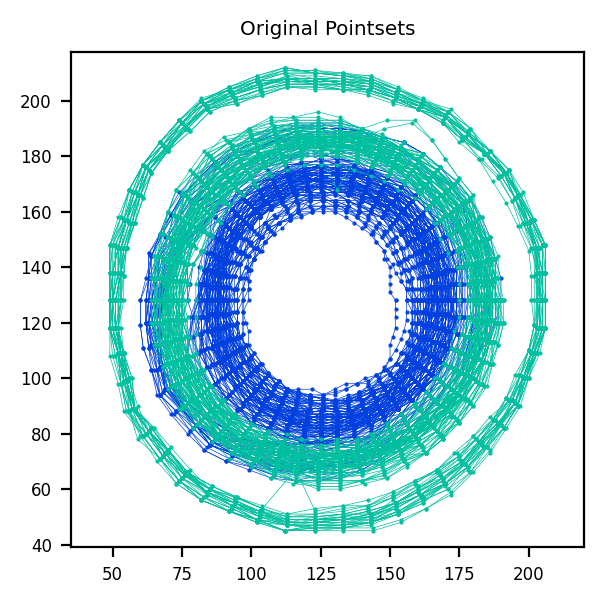

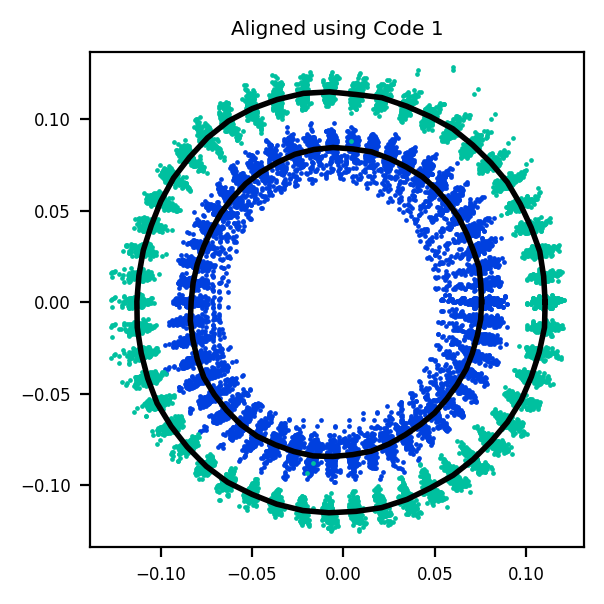

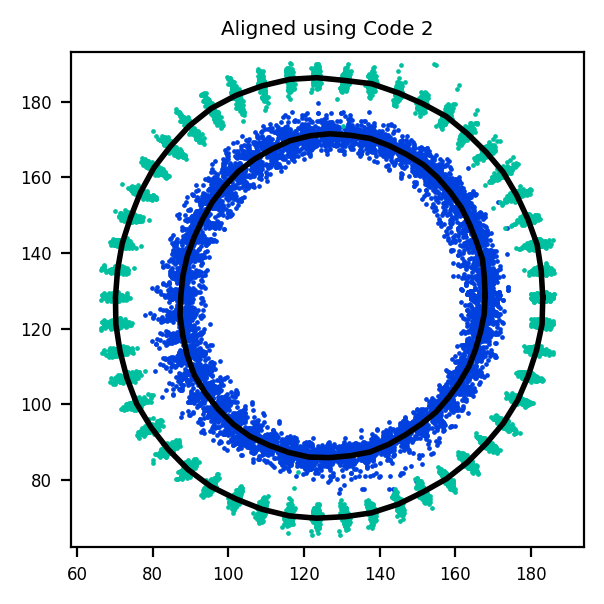

In [5]:
raw_colors = plt.get_cmap('winter')(np.linspace(0.25, 0.75, 2))
plt.figure(figsize=(3, 3), dpi=200)
# Inner
for i, shape in enumerate(inner_boundaries):
    plt.plot(shape[:, 0], shape[:, 1], color=raw_colors[0], marker='o', markersize=0.5, linewidth=0.25)
for i, shape in enumerate(outer_boundaries):
    plt.plot(shape[:, 0], shape[:, 1], color=raw_colors[1], marker='o', markersize=0.5, linewidth=0.25)
plt.title("Original Pointsets")
plt.axis('equal')
plt.tight_layout()
plt.show()

inner_aligned1, outer_aligned1, inner_mean1, outer_mean1 = code11_combined(inner_boundaries, outer_boundaries)
inner_aligned2, inner_mean2 = code22(inner_boundaries)
outer_aligned2, outer_mean2 = code22(outer_boundaries)


def plot_shapes(inner_points, outer_points, inner_mean, outer_mean, title):
    colors = plt.get_cmap('winter')(np.linspace(0.25, 0.75, 2))
    plt.figure(figsize=(3, 3), dpi=200)
    for idx, hand_shape in enumerate(inner_points):
        plt.scatter(hand_shape[:, 0], hand_shape[:, 1], color=colors[0], s=0.5)
    for idx, hand_shape in enumerate(outer_points):
        plt.scatter(hand_shape[:, 0], hand_shape[:, 1], color=colors[1], s=0.5)
    plt.plot(inner_mean[:, 0], inner_mean[:, 1], 'k-', linewidth=2, label='Inner Mean')
    plt.plot(outer_mean[:, 0], outer_mean[:, 1], 'k-', linewidth=2, label='Outer Mean')
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


plot_shapes(inner_aligned1, outer_aligned1, inner_mean1, outer_mean1, "Aligned using Code 1")
plot_shapes(inner_aligned2, outer_aligned2, inner_mean2, outer_mean2, "Aligned using Code 2")

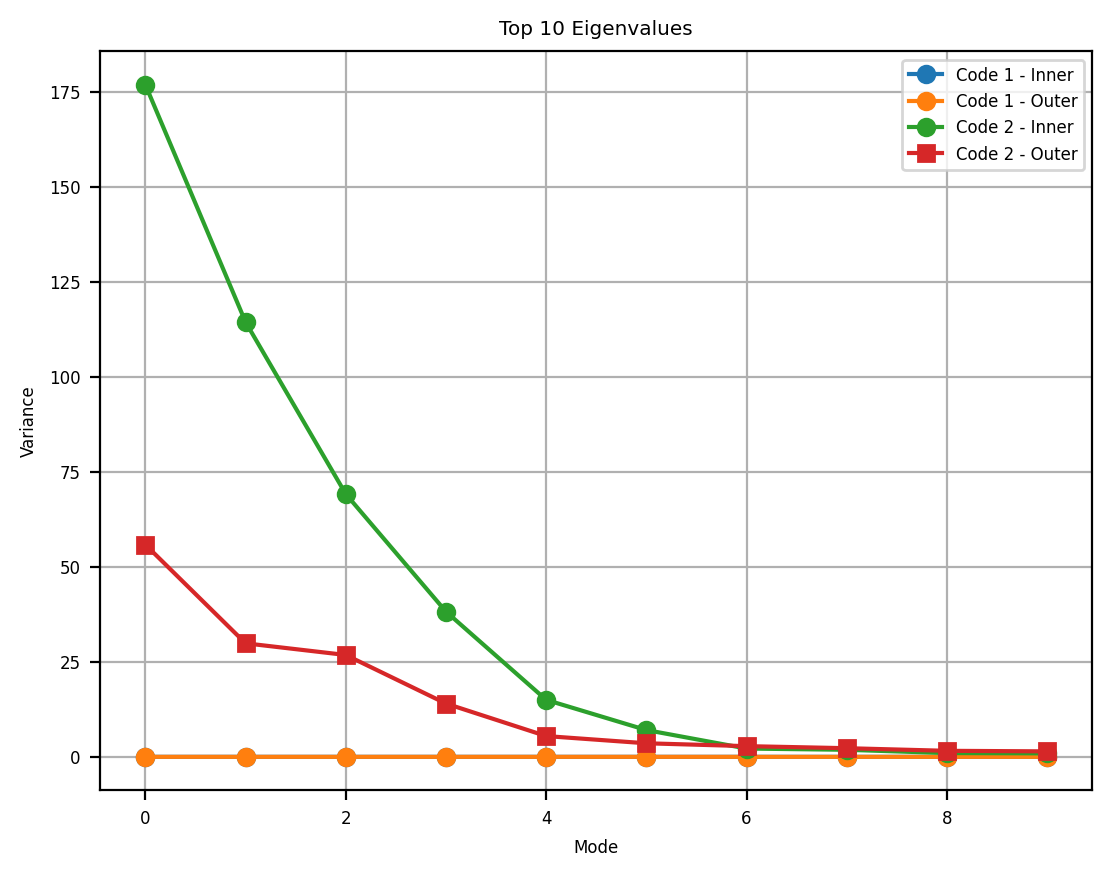

In [6]:
def compute_pca(aligned):
    n, p, d = aligned.shape
    flat = aligned.reshape(n, p * d)
    mean_flat = np.mean(flat, axis=0)
    centered = flat - mean_flat
    u, s, vt = np.linalg.svd(centered, full_matrices=False)
    eigenvalues = (s ** 2) / (n - 1)
    eigenvectors = vt.T
    return eigenvalues, eigenvectors, mean_flat.reshape(p, d)


inner_eigenvalues1, inner_eigenvectors1, _ = compute_pca(np.array(inner_aligned1))
outer_eigenvalues1, outer_eigenvectors1, _ = compute_pca(np.array(outer_aligned1))
inner_eigenvalues2, inner_eigenvectors2, _ = compute_pca(np.array(inner_aligned2))
outer_eigenvalues2, outer_eigenvectors2, _ = compute_pca(np.array(outer_aligned2))

plt.figure(dpi=200)
plt.plot(inner_eigenvalues1[:10], 'o-', label='Code 1 - Inner')
plt.plot(outer_eigenvalues1[:10], 'o-', label='Code 1 - Outer')
plt.plot(inner_eigenvalues2[:10], 'o-', label='Code 2 - Inner')
plt.plot(outer_eigenvalues2[:10], 's-', label='Code 2 - Outer')
plt.title("Top 10 Eigenvalues")
plt.xlabel("Mode")
plt.ylabel("Variance")
plt.legend()
plt.grid()
plt.show()

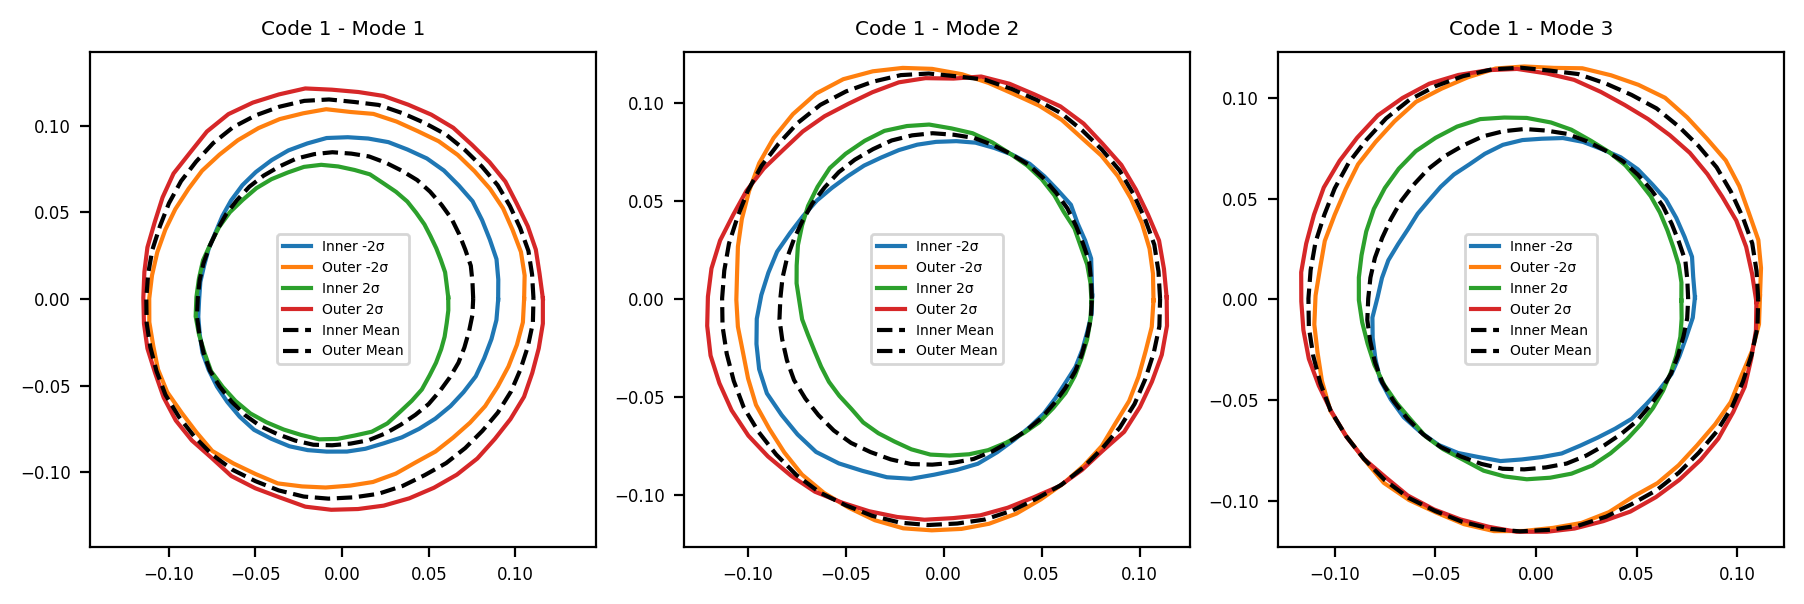

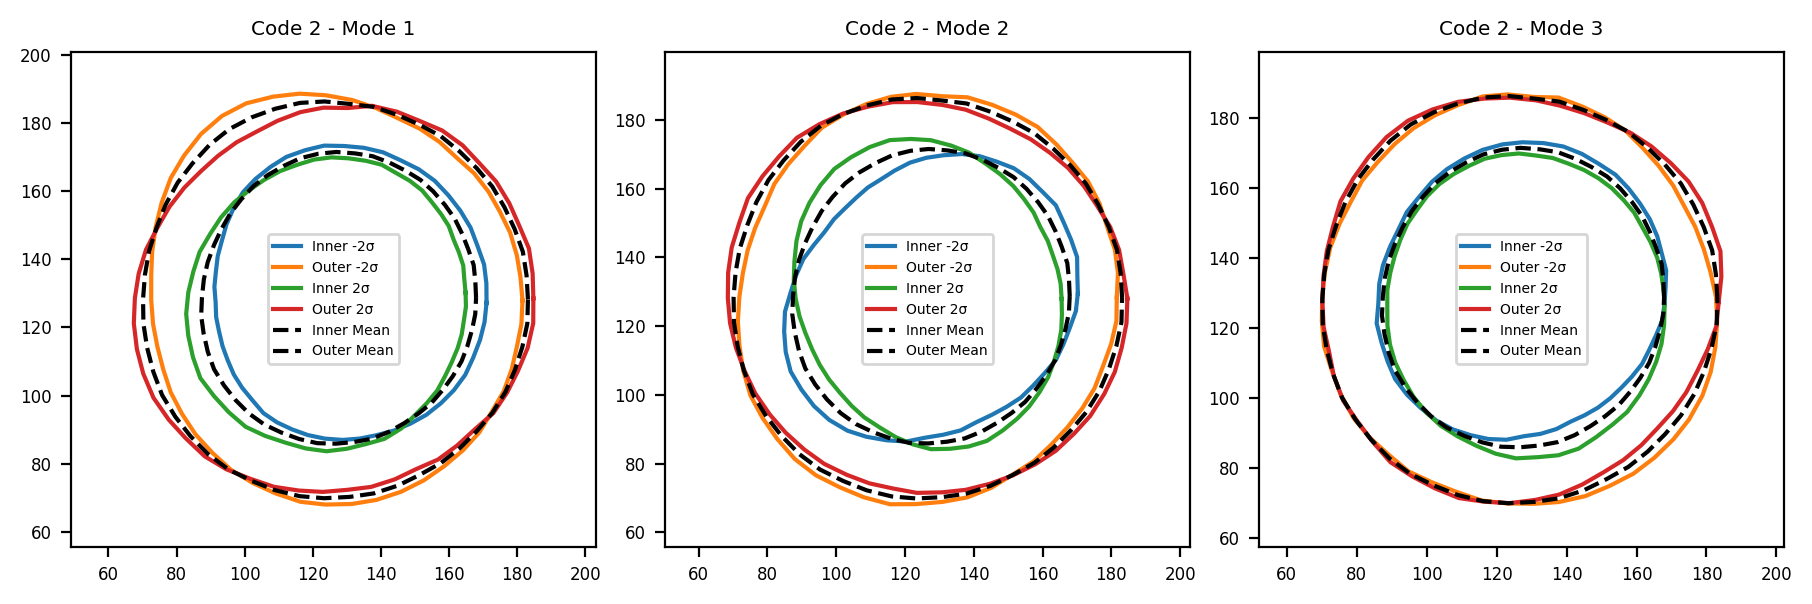

In [7]:
def show_modes(inner_mean_shape, outer_mean_shape, inner_eigenvalues, outer_eigenvalues, inner_eigenvectors,
               outer_eigenvectors, title_prefix):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3), dpi=200)
    for idx in range(3):
        inner_vec = inner_eigenvectors[:, idx].reshape(inner_mean_shape.shape)
        outer_vec = outer_eigenvectors[:, idx].reshape(outer_mean_shape.shape)
        inner_sigma = np.sqrt(inner_eigenvalues[idx])
        outer_sigma = np.sqrt(outer_eigenvalues[idx])
        idx_ax = axes[idx]
        for k in [-2, 2]:
            inner_handle_shape = inner_mean_shape + k * inner_sigma * inner_vec
            idx_ax.plot(inner_handle_shape[:, 0], inner_handle_shape[:, 1], label=f'Inner {k}σ')
            outer_handle_shape = outer_mean_shape + k * outer_sigma * outer_vec
            idx_ax.plot(outer_handle_shape[:, 0], outer_handle_shape[:, 1], label=f'Outer {k}σ')
        idx_ax.plot(inner_mean_shape[:, 0], inner_mean_shape[:, 1], 'k--', label='Inner Mean')
        idx_ax.plot(outer_mean_shape[:, 0], outer_mean_shape[:, 1], 'k--', label='Outer Mean')
        idx_ax.set_title(f'{title_prefix} - Mode {idx + 1}')
        idx_ax.axis('equal')
        idx_ax.legend(fontsize=5)
    plt.tight_layout()
    plt.show()


show_modes(inner_mean1, outer_mean1, inner_eigenvalues1, outer_eigenvalues1, inner_eigenvectors1, outer_eigenvectors1,
           "Code 1")
show_modes(inner_mean2, outer_mean2, inner_eigenvalues2, outer_eigenvalues2, inner_eigenvectors2, outer_eigenvectors2,
           "Code 2")